In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import imagehash
from collections import defaultdict
from PIL import Image
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
import pickle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import ResNet101, ConvNeXtBase, DenseNet121
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [2]:
# Path to your dataset
dataset_path = r"E:\STAT BRIO\Python\Ongoing\AI POWERED CROP DISEASE DETECTION\DATASET\3"

In [3]:
# List to store image paths and labels
data = []

# Walk through each subdirectory
for label in os.listdir(dataset_path):
    label_folder = os.path.join(dataset_path, label)
    if os.path.isdir(label_folder):
        for file in os.listdir(label_folder):
            file_path = os.path.join(label_folder, file)
            if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')):
                data.append({"image": file_path, "label": label})

# Create DataFrame
df = pd.DataFrame(data)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15077 entries, 0 to 15076
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   15077 non-null  object
 1   label   15077 non-null  object
dtypes: object(2)
memory usage: 235.7+ KB


In [5]:
df.head()

,image,label
0,E:\STAT BRIO\Python\Ongoing\AI POWERED CROP DI...,Corn common rust
1,E:\STAT BRIO\Python\Ongoing\AI POWERED CROP DI...,Corn common rust
2,E:\STAT BRIO\Python\Ongoing\AI POWERED CROP DI...,Corn common rust
3,E:\STAT BRIO\Python\Ongoing\AI POWERED CROP DI...,Corn common rust
4,E:\STAT BRIO\Python\Ongoing\AI POWERED CROP DI...,Corn common rust


In [6]:
# Check how many unique classes
num_classes = df['label'].nunique()
print(f"Number of unique classes: {num_classes}")

Number of unique classes: 12


In [7]:
df['label'].unique()

array(['Corn common rust', 'Corn gray leaf spot', 'Corn healthy',
       'Potato bacterial wilt', 'Potato healthy', 'Potato leafroll virus',
       'Sugercane healthy', 'Sugercane red rot', 'Sugercane yellow leaf',
       'Tomato healthy', 'Tomato leaf curl', 'Tomato septoria leaf spot'],
      dtype=object)

In [8]:
# Count number of images per class
class_counts = df['label'].value_counts()
print("Number of images per class: ")
print(class_counts)

Number of images per class: 
label
Tomato leaf curl             5357
Tomato septoria leaf spot    1771
Tomato healthy               1590
Corn common rust             1192
Corn healthy                 1162
Potato healthy                851
Potato bacterial wilt         569
Potato leafroll virus         527
Sugercane healthy             522
Sugercane red rot             518
Corn gray leaf spot           513
Sugercane yellow leaf         505
Name: count, dtype: int64


C:\Users\Naveen\AppData\Local\Temp\ipykernel_2880\1194771536.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


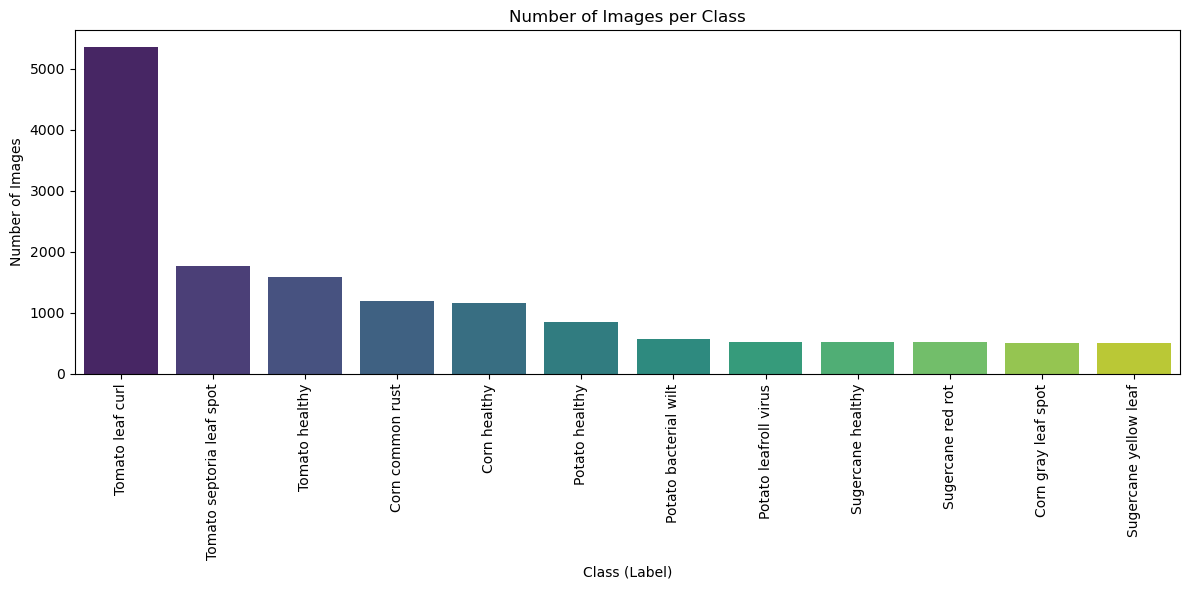

In [9]:
# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.title("Number of Images per Class")
plt.xlabel("Class (Label)")
plt.ylabel("Number of Images")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

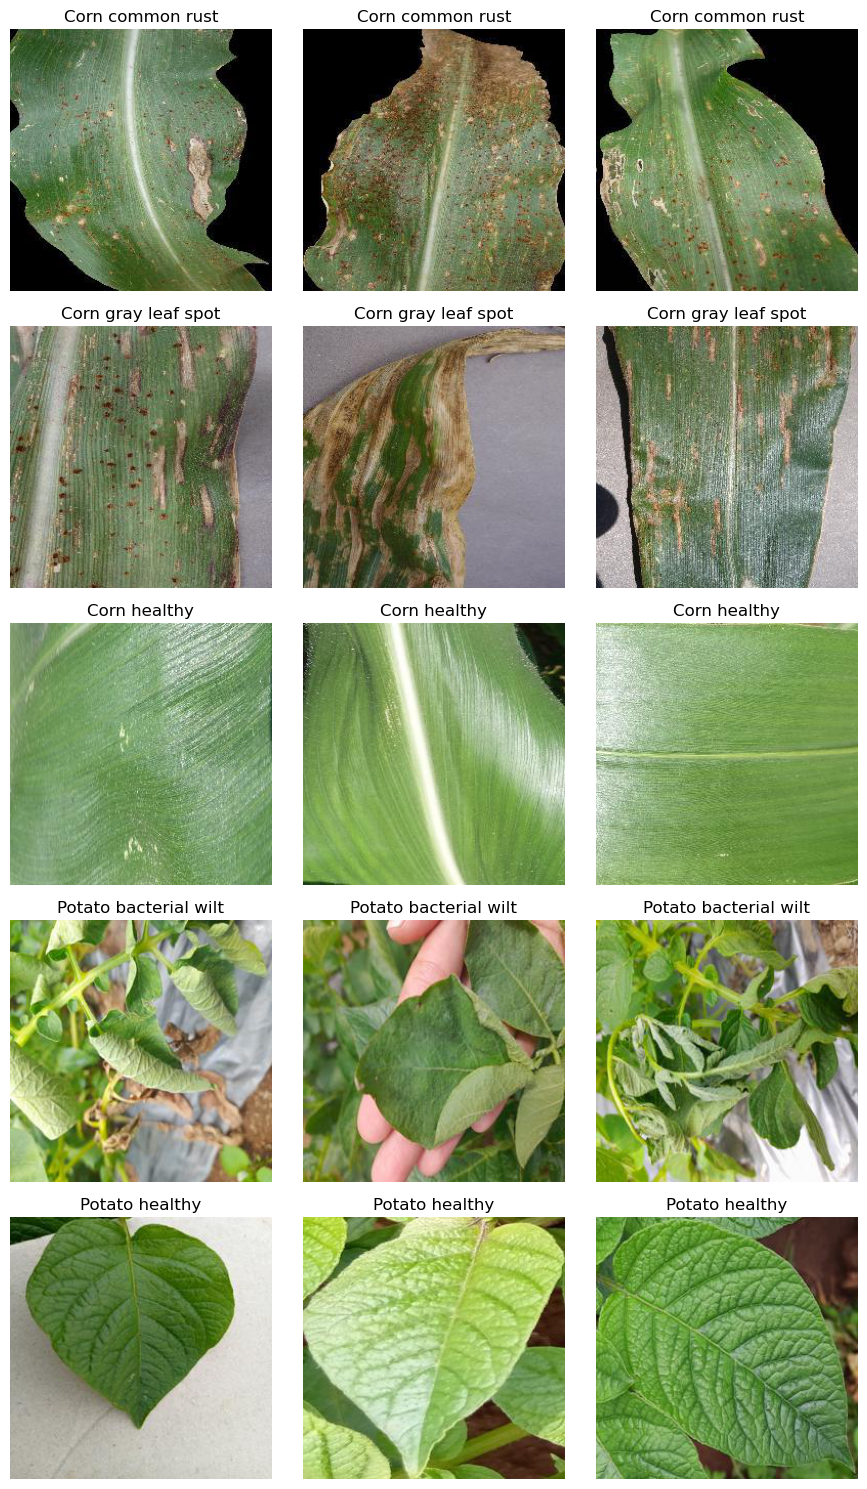

In [10]:
# Set number of classes and samples per class to display
n_classes = min(5, df['label'].nunique())
samples_per_class = 3

unique_labels = df['label'].unique()

plt.figure(figsize=(samples_per_class * 3, n_classes * 3))

for i, label in enumerate(unique_labels[:n_classes]):
    label_df = df[df['label'] == label]
    samples = label_df.sample(n=min(samples_per_class, len(label_df)))

    for j, (_, row) in enumerate(samples.iterrows()):
        img = Image.open(row['image']).convert('RGB')
        plt.subplot(n_classes, samples_per_class, i * samples_per_class + j + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')

plt.tight_layout()
plt.show()

In [11]:
# Get dimensions of each image
def get_image_shape(path):
    with Image.open(path) as img:
        return img.size  # returns (width, height)

In [12]:
df['dimensions'] = df['image'].apply(get_image_shape)
df['width'] = df['dimensions'].apply(lambda x: x[0])
df['height'] = df['dimensions'].apply(lambda x: x[1])

In [13]:
# Basic stats
print(df[['width', 'height']].describe())

              width        height
count  15077.000000  15077.000000
mean     269.912582    277.496253
std       58.672701     72.881499
min      256.000000    256.000000
25%      256.000000    256.000000
50%      256.000000    256.000000
75%      256.000000    256.000000
max      782.000000    730.000000


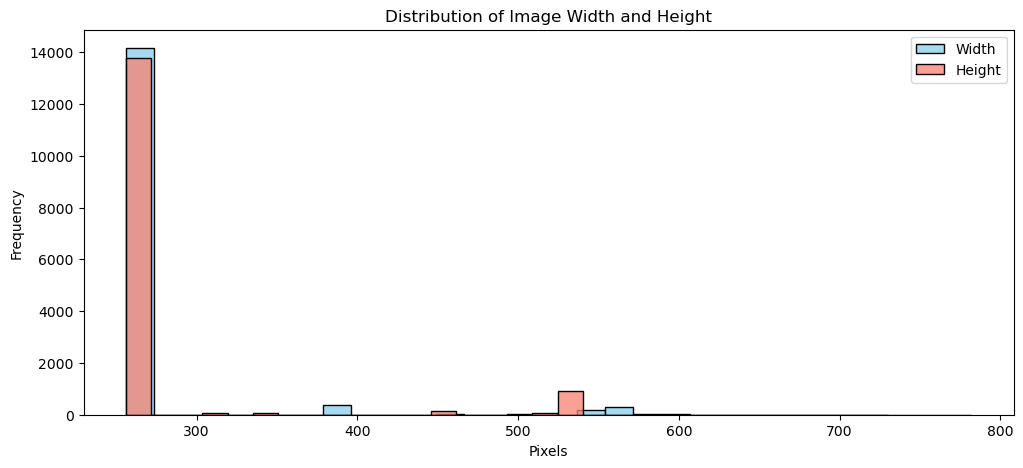

In [14]:
plt.figure(figsize=(12, 5))
sns.histplot(df['width'], bins=30, color='skyblue', label='Width')
sns.histplot(df['height'], bins=30, color='salmon', label='Height')
plt.legend()
plt.title('Distribution of Image Width and Height')
plt.xlabel('Pixels')
plt.ylabel('Frequency')
plt.show()

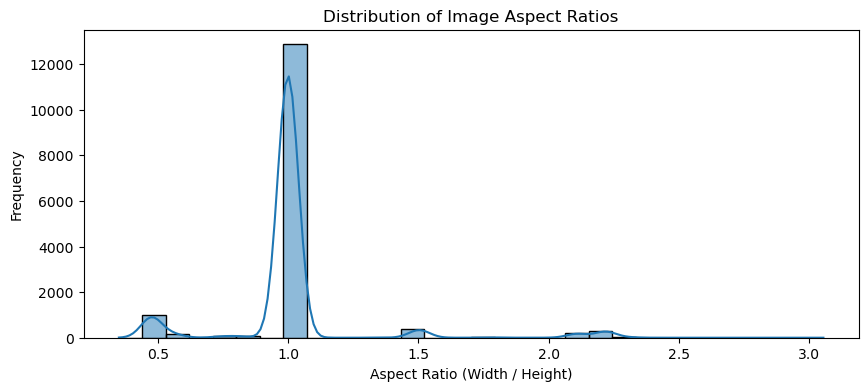

In [15]:
df['aspect_ratio'] = df['width'] / df['height']

plt.figure(figsize=(10, 4))
sns.histplot(df['aspect_ratio'], bins=30, kde=True)
plt.title('Distribution of Image Aspect Ratios')
plt.xlabel('Aspect Ratio (Width / Height)')
plt.ylabel('Frequency')
plt.show()

In [16]:
def compute_brightness(img_path):
    img = Image.open(img_path).convert('L')  # convert to grayscale
    stat = img.getdata()
    return sum(stat) / len(stat)

df['brightness'] = df['image'].apply(compute_brightness)

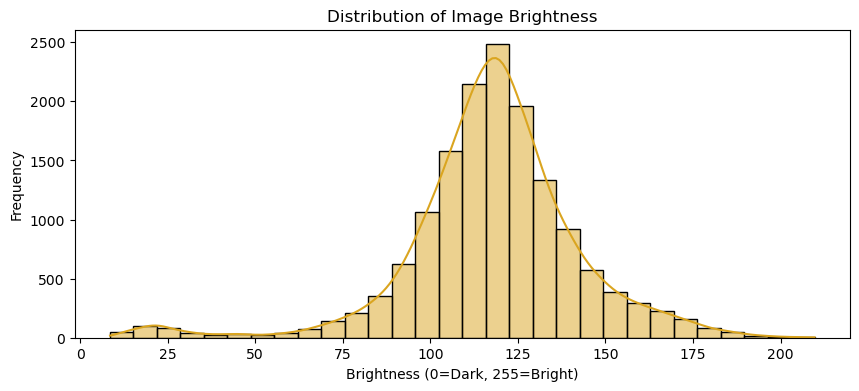

In [17]:
plt.figure(figsize=(10, 4))
sns.histplot(df['brightness'], bins=30, color='goldenrod', kde=True)
plt.title('Distribution of Image Brightness')
plt.xlabel('Brightness (0=Dark, 255=Bright)')
plt.ylabel('Frequency')
plt.show()

In [18]:
def plot_rgb_histogram(img_path):
    img = Image.open(img_path).convert('RGB')
    r, g, b = img.split()

    plt.figure(figsize=(10, 3))
    plt.hist(r.getdata(), bins=256, color='red', alpha=0.5, label='Red')
    plt.hist(g.getdata(), bins=256, color='green', alpha=0.5, label='Green')
    plt.hist(b.getdata(), bins=256, color='blue', alpha=0.5, label='Blue')
    plt.title(f'RGB Histogram: {os.path.basename(img_path)}')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.show()

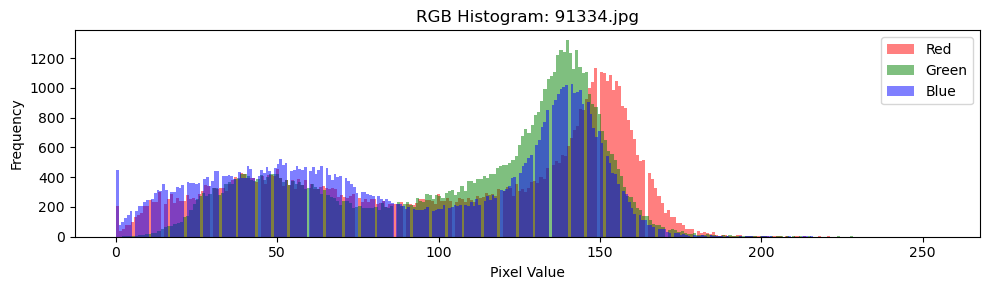

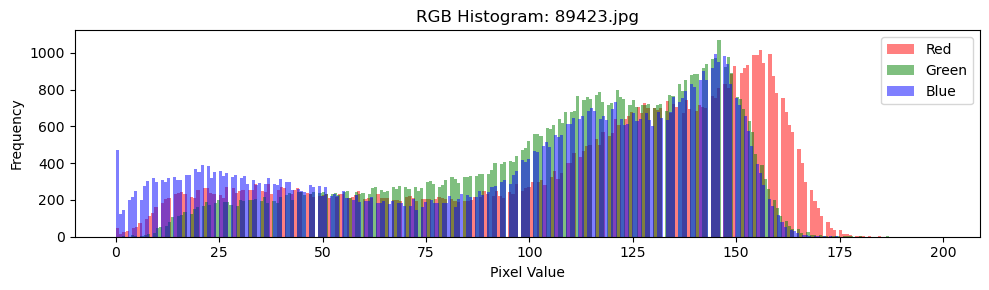

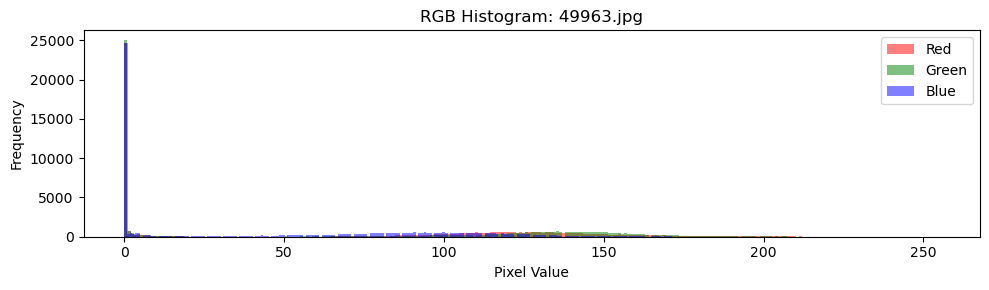

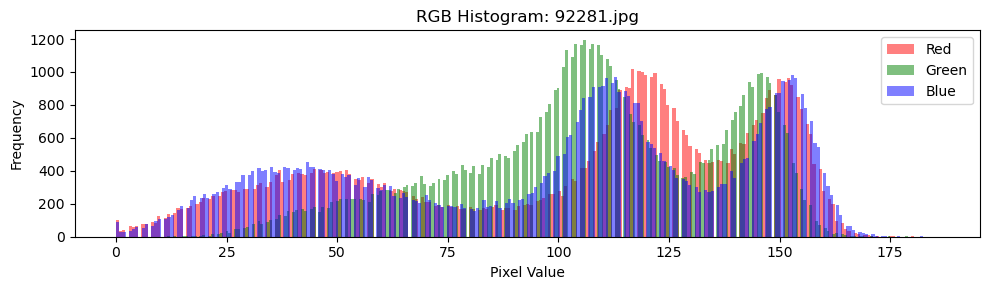

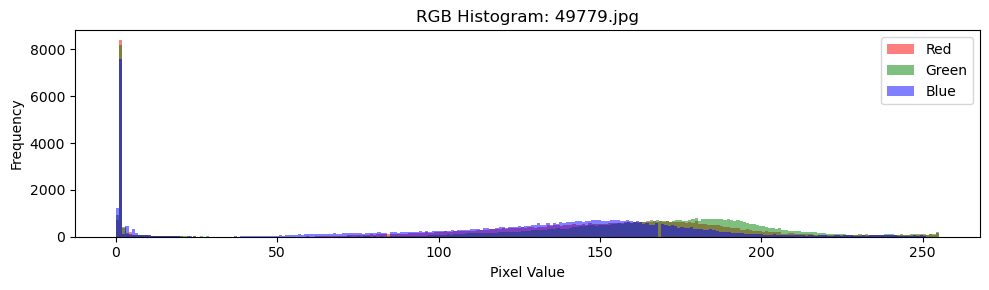

In [19]:
# Show for 3 random images
for path in df.sample(5)['image']:
    plot_rgb_histogram(path)

In [20]:
# Compute hash for each image
df['hash'] = df['image'].apply(lambda x: str(imagehash.average_hash(Image.open(x).convert('RGB'))))

# Count duplicates
hash_groups = df.groupby('hash')['image'].apply(list)
duplicates = hash_groups[hash_groups.apply(len) > 1]

Number of duplicate hash groups: 135
Sample duplicate group:


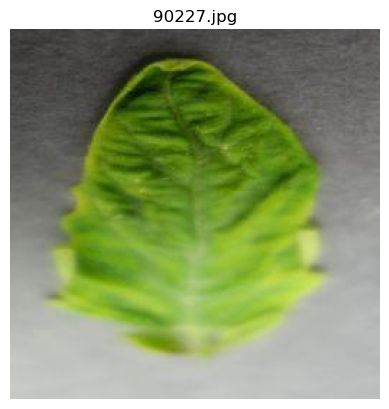

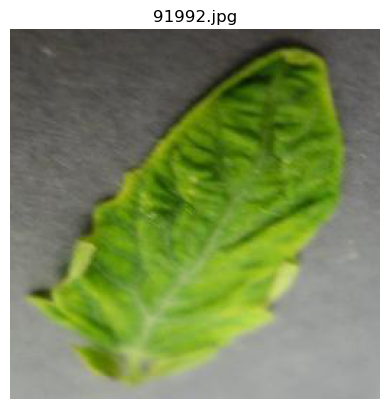

In [21]:
print(f"Number of duplicate hash groups: {len(duplicates)}")
print("Sample duplicate group:")
# Display a sample duplicate group
for i, paths in enumerate(duplicates.head(1)):
    for path in paths:
        img = Image.open(path)
        plt.imshow(img)
        plt.title(os.path.basename(path))
        plt.axis('off')
        plt.show()

In [22]:
TARGET_SAMPLES = 500

balanced_df = pd.concat([
    resample(df[df['label'] == label],
             replace=True if len(df[df['label'] == label]) < TARGET_SAMPLES else False,
             n_samples=TARGET_SAMPLES,
             random_state=42)
    for label in df['label'].unique()
])

balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(balanced_df['label'].value_counts())

label
Potato bacterial wilt        500
Sugercane red rot            500
Corn common rust             500
Potato healthy               500
Tomato leaf curl             500
Corn healthy                 500
Corn gray leaf spot          500
Potato leafroll virus        500
Sugercane yellow leaf        500
Tomato septoria leaf spot    500
Sugercane healthy            500
Tomato healthy               500
Name: count, dtype: int64


In [23]:
label_encoder = LabelEncoder()
balanced_df['encoded_label'] = label_encoder.fit_transform(balanced_df['label'])

In [24]:
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

In [25]:
label_names = label_encoder.classes_

In [26]:
# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [27]:
# Image preprocessing function
def process_path(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0  # Normalize to [0, 1]
    return img, label

In [28]:
train_df, val_df = train_test_split(
    balanced_df,
    test_size=0.2,
    stratify=balanced_df['encoded_label'],
    random_state=42
)

In [29]:
# Convert DataFrame columns to tensors
train_paths = train_df['image'].values
train_labels = train_df['encoded_label'].values

In [30]:
val_paths = val_df['image'].values
val_labels = val_df['encoded_label'].values

In [31]:
# Wrap into tf.data.Dataset
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))

In [32]:
# Apply preprocessing
train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

In [33]:
# Shuffle, batch, prefetch
train_ds = train_ds.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [34]:
NUM_CLASSES = balanced_df['encoded_label'].nunique()
EPOCHS = 35
N = 20

In [35]:
# Load base model
base_model_resnet101 = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze the last N layers of ResNet101
base_model_resnet101.trainable = True

# Freeze all layers except the last N
for layer in base_model_resnet101.layers[:-N]:
    layer.trainable = False

# (Optional) Freeze BatchNorm layers even in the last N
for layer in base_model_resnet101.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

# Add custom head
model_resnet101 = models.Sequential([
    base_model_resnet101,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

In [36]:
model_resnet101.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 12)                3084      
                                                                 
Total params: 43,185,804
Trainable params: 9,446,668
Non-trainable params: 33,739,136
____________________________________

In [37]:
base_model_convnextbase = ConvNeXtBase(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze the last N layers of ConvNeXtBase
base_model_convnextbase.trainable = True

# Freeze all layers except the last N
for layer in base_model_convnextbase.layers[:-N]:
    layer.trainable = False

# (Optional) Freeze BatchNorm layers even in the last N
for layer in base_model_convnextbase.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

# Add custom head
model_convnextbase = models.Sequential([
    base_model_convnextbase,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

In [38]:
model_convnextbase.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convnext_base (Functional)  (None, 7, 7, 1024)        87566464  
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 256)               262400    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 12)                3084      
                                                                 
Total params: 87,831,948
Trainable params: 17,164,556
Non-trainable params: 70,667,392
_________________________________

In [39]:
base_model_densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze the last N layers of DenseNet121
base_model_densenet.trainable = True

# Freeze all layers except the last N
for layer in base_model_densenet.layers[:-N]:
    layer.trainable = False

# (Optional) Freeze BatchNorm layers even in the last N
for layer in base_model_densenet.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

# Add custom head
model_densenet = models.Sequential([
    base_model_densenet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

In [40]:
model_densenet.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d_2   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 256)               262400    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 12)                3084      
                                                                 
Total params: 7,302,988
Trainable params: 625,932
Non-trainable params: 6,677,056
______________________________________

In [41]:
# Reduce LR if validation accuracy stops improving
lr_callback = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,        # reduce LR by half
    patience=2,        # wait for 2 epochs of no improvement
    verbose=2,
    min_lr=1e-6
)

In [42]:
# Train all three models
models_histories = {}

In [43]:
# Helper function to build and train models
def build_and_train_model(model, name):
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[lr_callback], verbose=2)
    return model, history

In [44]:
model_resnet, hist_resnet = build_and_train_model(model_resnet101, 'ResNet101')
models_histories['ResNet101'] = (model_resnet, hist_resnet)

Epoch 1/35
150/150 - 26s - loss: 2.4639 - accuracy: 0.1171 - val_loss: 2.2352 - val_accuracy: 0.2058 - lr: 0.0010 - 26s/epoch - 171ms/step
Epoch 2/35
150/150 - 17s - loss: 2.0732 - accuracy: 0.2454 - val_loss: 1.8983 - val_accuracy: 0.3267 - lr: 0.0010 - 17s/epoch - 113ms/step
Epoch 3/35
150/150 - 17s - loss: 1.6392 - accuracy: 0.4010 - val_loss: 1.4156 - val_accuracy: 0.4792 - lr: 0.0010 - 17s/epoch - 113ms/step
Epoch 4/35
150/150 - 17s - loss: 1.3987 - accuracy: 0.4823 - val_loss: 1.0506 - val_accuracy: 0.6158 - lr: 0.0010 - 17s/epoch - 113ms/step
Epoch 5/35
150/150 - 17s - loss: 1.1448 - accuracy: 0.5813 - val_loss: 0.9922 - val_accuracy: 0.6142 - lr: 0.0010 - 17s/epoch - 113ms/step
Epoch 6/35
150/150 - 18s - loss: 1.0508 - accuracy: 0.6117 - val_loss: 0.8467 - val_accuracy: 0.6825 - lr: 0.0010 - 18s/epoch - 117ms/step
Epoch 7/35
150/150 - 17s - loss: 0.9352 - accuracy: 0.6452 - val_loss: 0.9087 - val_accuracy: 0.6742 - lr: 0.0010 - 17s/epoch - 114ms/step
Epoch 8/35

Epoch 8: Reduce

In [45]:
model_conv, hist_conv = build_and_train_model(model_convnextbase, 'ConvNeXtBase')
models_histories['ConvNeXtBase'] = (model_conv, hist_conv)

Epoch 1/35
150/150 - 64s - loss: 1.3643 - accuracy: 0.5362 - val_loss: 0.6689 - val_accuracy: 0.7767 - lr: 0.0010 - 64s/epoch - 425ms/step
Epoch 2/35
150/150 - 54s - loss: 0.6679 - accuracy: 0.7517 - val_loss: 0.5585 - val_accuracy: 0.7950 - lr: 0.0010 - 54s/epoch - 358ms/step
Epoch 3/35
150/150 - 54s - loss: 0.5311 - accuracy: 0.8069 - val_loss: 0.5601 - val_accuracy: 0.8042 - lr: 0.0010 - 54s/epoch - 357ms/step
Epoch 4/35
150/150 - 54s - loss: 0.4379 - accuracy: 0.8442 - val_loss: 0.5277 - val_accuracy: 0.8258 - lr: 0.0010 - 54s/epoch - 359ms/step
Epoch 5/35
150/150 - 53s - loss: 0.3780 - accuracy: 0.8604 - val_loss: 0.5521 - val_accuracy: 0.8425 - lr: 0.0010 - 53s/epoch - 356ms/step
Epoch 6/35
150/150 - 54s - loss: 0.3219 - accuracy: 0.8906 - val_loss: 0.5400 - val_accuracy: 0.8325 - lr: 0.0010 - 54s/epoch - 358ms/step
Epoch 7/35
150/150 - 53s - loss: 0.2588 - accuracy: 0.9148 - val_loss: 0.5557 - val_accuracy: 0.8558 - lr: 0.0010 - 53s/epoch - 357ms/step
Epoch 8/35
150/150 - 54s - 

In [46]:
model_dense, hist_densenet = build_and_train_model(model_densenet, 'DenseNet121')
models_histories['DenseNet121'] = (model_dense, hist_densenet)

Epoch 1/35
150/150 - 16s - loss: 0.4889 - accuracy: 0.8319 - val_loss: 0.1316 - val_accuracy: 0.9525 - lr: 0.0010 - 16s/epoch - 104ms/step
Epoch 2/35
150/150 - 12s - loss: 0.1414 - accuracy: 0.9529 - val_loss: 0.1171 - val_accuracy: 0.9583 - lr: 0.0010 - 12s/epoch - 81ms/step
Epoch 3/35
150/150 - 12s - loss: 0.0941 - accuracy: 0.9685 - val_loss: 0.0620 - val_accuracy: 0.9783 - lr: 0.0010 - 12s/epoch - 81ms/step
Epoch 4/35
150/150 - 12s - loss: 0.0621 - accuracy: 0.9771 - val_loss: 0.0637 - val_accuracy: 0.9783 - lr: 0.0010 - 12s/epoch - 81ms/step
Epoch 5/35
150/150 - 12s - loss: 0.0459 - accuracy: 0.9840 - val_loss: 0.0451 - val_accuracy: 0.9833 - lr: 0.0010 - 12s/epoch - 81ms/step
Epoch 6/35
150/150 - 12s - loss: 0.0517 - accuracy: 0.9848 - val_loss: 0.0578 - val_accuracy: 0.9792 - lr: 0.0010 - 12s/epoch - 81ms/step
Epoch 7/35
150/150 - 12s - loss: 0.0289 - accuracy: 0.9894 - val_loss: 0.0442 - val_accuracy: 0.9858 - lr: 0.0010 - 12s/epoch - 81ms/step
Epoch 8/35
150/150 - 12s - loss: 

In [47]:
def plot_metric(histories, metric, title, ylabel):
    plt.figure(figsize=(10, 6))
    for name, (_, history) in histories.items():
        plt.plot(history.history[metric], label=f'{name} {metric}', linewidth=2)
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

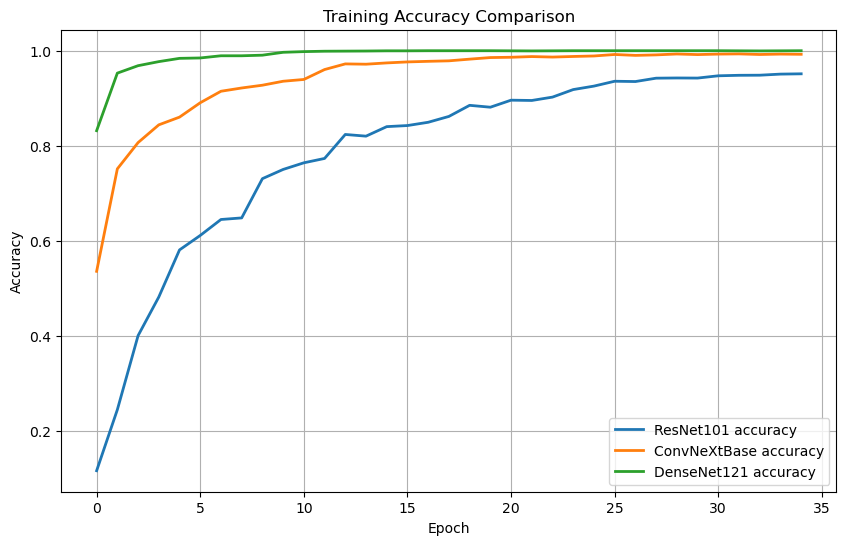

In [48]:
# Plot Training Accuracy
plot_metric(models_histories, 'accuracy', 'Training Accuracy Comparison', 'Accuracy')

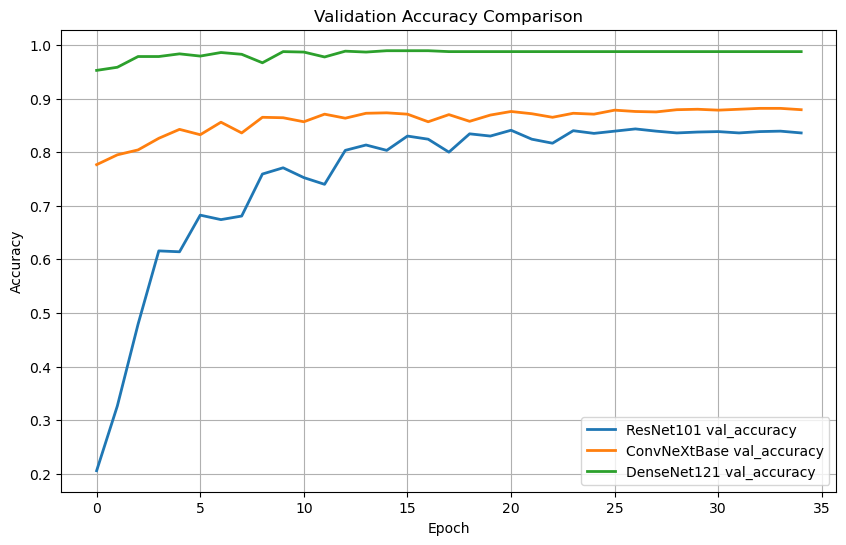

In [49]:
# Plot Validation Accuracy
plot_metric(models_histories, 'val_accuracy', 'Validation Accuracy Comparison', 'Accuracy')

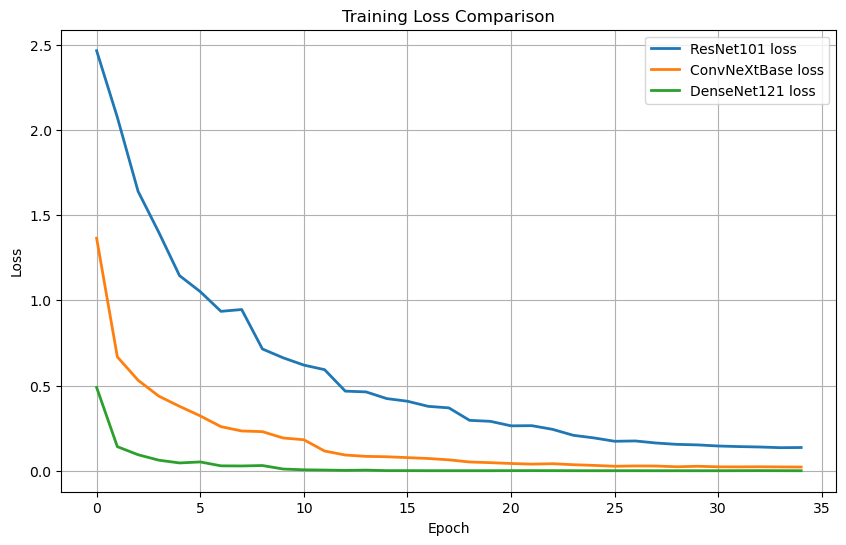

In [50]:
# Plot Training Loss
plot_metric(models_histories, 'loss', 'Training Loss Comparison', 'Loss')

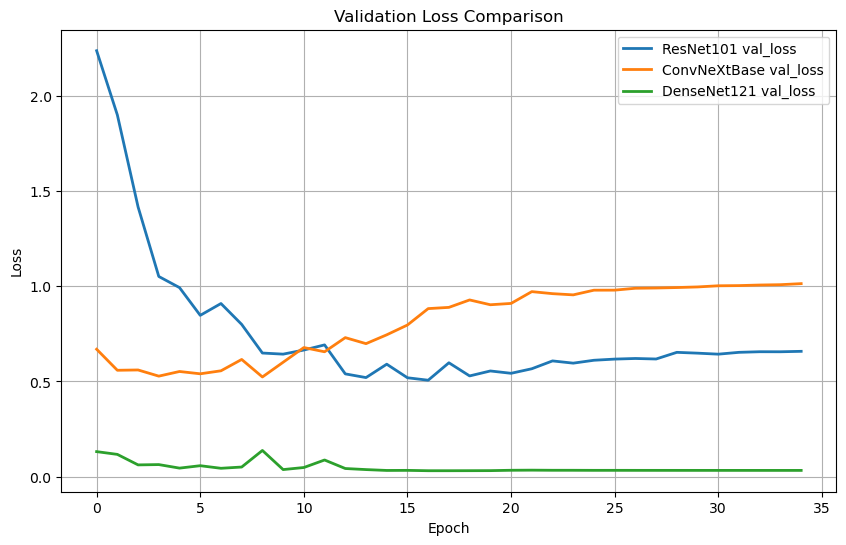

In [51]:
# Plot Validation Loss
plot_metric(models_histories, 'val_loss', 'Validation Loss Comparison', 'Loss')

In [52]:
# Evaluate and plot confusion matrices
def evaluate_and_plot_cm(model, name):
    y_true, y_pred = [], []
    
    for images, labels in val_ds:
        preds = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))

    cm = confusion_matrix(y_true, y_pred)
    print(f"Classification Report for {name}:\n", classification_report(y_true, y_pred, target_names=label_names))

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
    plt.figure(figsize=(8, 6))
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

1/1 [==============================] - 1s 724ms/step
Classification Report for ResNet101:
                            precision    recall  f1-score   support

         Corn common rust       0.98      0.95      0.96       100
      Corn gray leaf spot       0.87      0.91      0.89       100
             Corn healthy       0.84      0.81      0.83       100
    Potato bacterial wilt       0.90      0.86      0.88       100
           Potato healthy       0.86      0.87      0.87       100
    Potato leafroll virus       0.98      1.00      0.99       100
        Sugercane healthy       0.68      0.63      0.65       100
        Sugercane red rot       0.67      0.62      0.64       100
    Sugercane yellow leaf       0.52      0.61      0.56       100
           Tomato healthy       0.96      0.98      0.97       100
         Tomato leaf curl       0.91      0.92      0.92       100
Tomato septoria leaf spot       0.90      0.87      0.88       100

                 accuracy           

<Figure size 800x600 with 0 Axes>

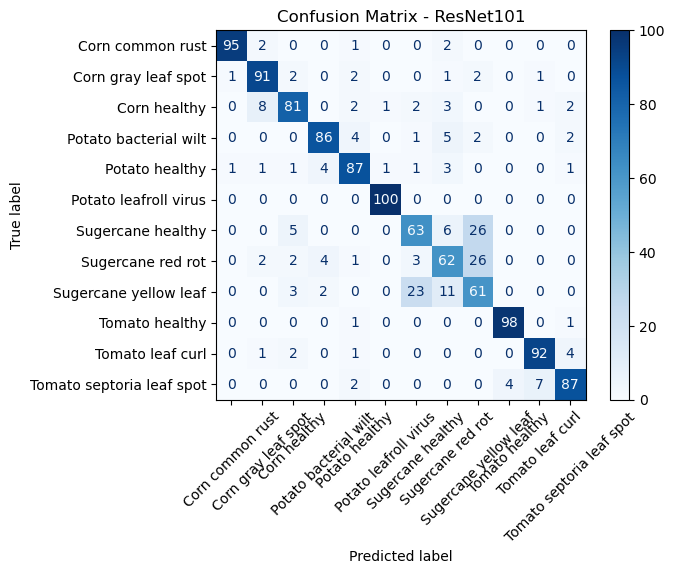

1/1 [==============================] - 1s 1s/step
Classification Report for ConvNeXtBase:
                            precision    recall  f1-score   support

         Corn common rust       0.99      0.98      0.98       100
      Corn gray leaf spot       0.85      0.94      0.89       100
             Corn healthy       0.90      0.88      0.89       100
    Potato bacterial wilt       0.94      0.96      0.95       100
           Potato healthy       0.96      0.89      0.92       100
    Potato leafroll virus       1.00      0.98      0.99       100
        Sugercane healthy       0.79      0.75      0.77       100
        Sugercane red rot       0.73      0.80      0.76       100
    Sugercane yellow leaf       0.66      0.57      0.61       100
           Tomato healthy       0.91      0.97      0.94       100
         Tomato leaf curl       0.90      0.94      0.92       100
Tomato septoria leaf spot       0.92      0.89      0.90       100

                 accuracy           

<Figure size 800x600 with 0 Axes>

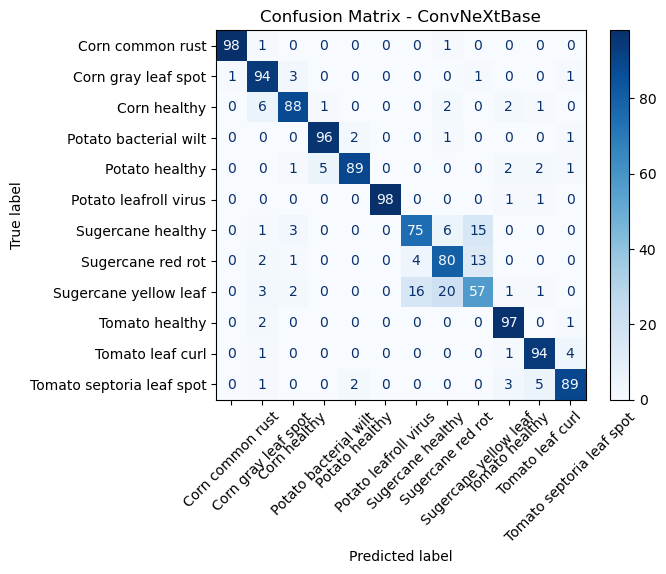

1/1 [==============================] - 1s 725ms/step
Classification Report for DenseNet121:
                            precision    recall  f1-score   support

         Corn common rust       1.00      1.00      1.00       100
      Corn gray leaf spot       1.00      1.00      1.00       100
             Corn healthy       1.00      1.00      1.00       100
    Potato bacterial wilt       0.99      0.99      0.99       100
           Potato healthy       0.99      0.99      0.99       100
    Potato leafroll virus       1.00      1.00      1.00       100
        Sugercane healthy       0.96      0.95      0.95       100
        Sugercane red rot       0.97      0.98      0.98       100
    Sugercane yellow leaf       0.94      0.94      0.94       100
           Tomato healthy       1.00      1.00      1.00       100
         Tomato leaf curl       1.00      1.00      1.00       100
Tomato septoria leaf spot       1.00      1.00      1.00       100

                 accuracy         

<Figure size 800x600 with 0 Axes>

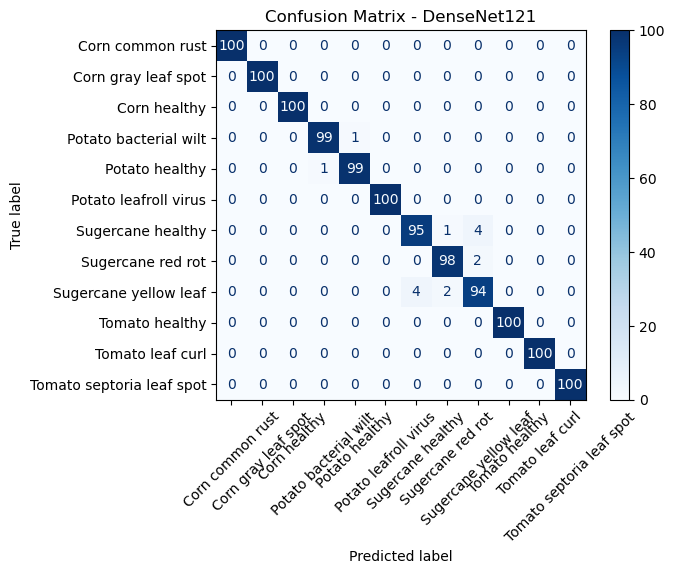

In [53]:
for name, (model, _) in models_histories.items():
    evaluate_and_plot_cm(model, name)

In [ ]:
model_resnet.save("ResNet_101.keras")
model_conv.save("ConvNeXtBase.keras")
model_dense.save("DenseNet_121.keras")